# Finding the ground state of spins in a Kagome lattice using a variational quantum eigensolver (VQE)

In [1]:
# General imports
import numpy as np
from time import time
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [2]:
# Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit import IBMQ

In [3]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# IBMQ.save_account(TOKEN)
# IBMQ.save_account(token='a25c2de7fba634b2157af2ffb30cdcc9308e14a848e7ab959998e09039d19b4bb8310654409a6be536191b7181d01036b0df144e791d1b9c700281d2d9e8f098')
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#IBMQ.providers()
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# print(provider.backends())

# Real backend; needed for transpilation later on
guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
# from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
# guadalupe = FakeGuadalupe()

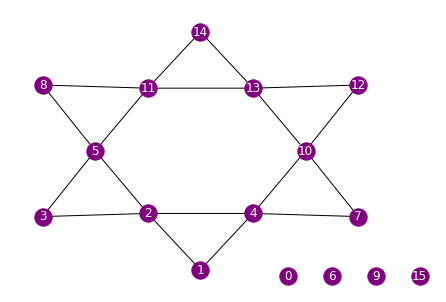

In [4]:
import rustworkx as rx
from qiskit_nature.problems.second_quantization.lattice import Lattice

# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [5]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from heisenberg_model import HeisenbergModel

# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

## Ansatz for the quantum circuit
We present a parametrized quantum circuit for the 12-qubit Kagome lattice that uses only 11 parameters. Each triangle in the lattice will be entangled subsequently into a (parametrized) $W$ state, $W = |100\rangle + a_1(\theta) |010\rangle + a_2(\theta) |001\rangle$. This is achieved by the followin circuit. 

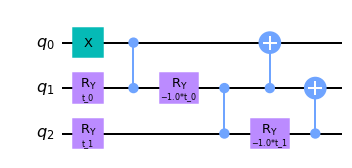

In [6]:
triangle = QuantumCircuit(3)

def W_entangler(circuit,q_array,param_name):
    # takes a quantum circuit and creates a parametrised W state 
    # between the qubits specified in q_array, with parameters specified in a vector param_name
    circuit.x(q_array[0])  # apply NOT to the first qubit in q_array
    k = len(q_array) - 1   # need a number of parameters one less than the number of qubits
    theta = []
    for i in range(k):
        theta.append(Parameter(param_name+'_'+str(i)))
    
    for j in range(k):  # this applies a rotation to qubit at index j+1 in the array 
        circuit.ry(theta[j],q_array[j+1])
        circuit.cz(q_array[j],q_array[j+1])
        circuit.ry(-theta[j],q_array[j+1])
    for j in range(k):  # entangle all the qubits with CNOT gates
        circuit.cx(q_array[j+1],q_array[j])
    return circuit

W_entangler(triangle,[0,1,2],'t')
triangle.draw("mpl")

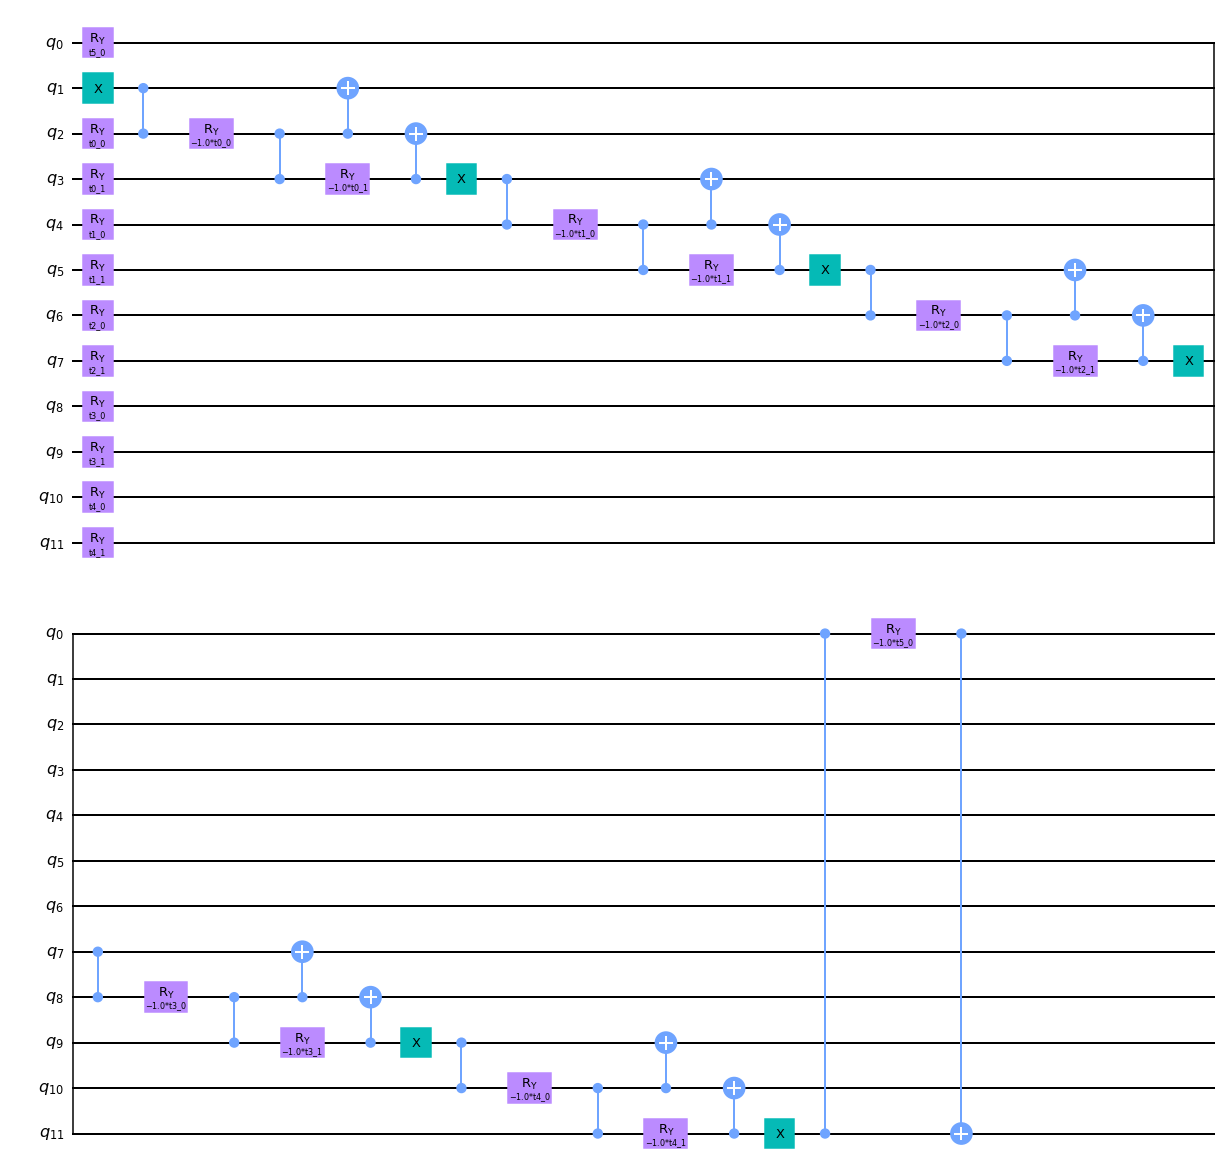

In [7]:
kagome_ansatz = QuantumCircuit(12)  
# use a quantum circuit of 12 qubits corresponding to the spins in the Kagome lattice

for i in range(5):      
    # create W states between 3 qubits in each of 5 subsequent triangles of the Kagome lattice 
    W_entangler(kagome_ansatz,[2*i+1,(2*i+2)%12,(2*i+3)%12],'t'+str(i))

# entangle the last qubit with the first (still free) qubit in the lattice
W_entangler(kagome_ansatz,[11,0],'t'+str(5))

kagome_ansatz.draw('mpl')

In [8]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
ansatz = kagome_ansatz

q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(ansatz, backend=guadalupe, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
print(ansatz_opt.parameters)
# ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 66), ('sx', 44), ('cx', 22), ('x', 6)])
number of parameters in the circuit: 11
ParameterView([Parameter(t0_0), Parameter(t0_1), Parameter(t1_0), Parameter(t1_1), Parameter(t2_0), Parameter(t2_1), Parameter(t3_0), Parameter(t3_1), Parameter(t4_0), Parameter(t4_1), Parameter(t5_0)])


In [9]:
from qiskit.algorithms.optimizers import SPSA

class LearningRate():
    
    def __iter__(self):
        self.learning_rate = 0.
        return self
    
    def __next__(self):
        self.learning_rate *= 0.999
        print(self.learning_rate)
        if self.learning_rate < 0.001:
            raise StopIteration
        return self.learning_rate
    
class Perturbation():

    def __iter__(self):
        serf.perturbation = 0.1
        return self
    def __next__(self):
        return self.perturbation
    
lr = iter(LearningRate())

optimizer = SPSA(maxiter=100)

In [19]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        # x0 = np.pi/2 * (np.random.rand(self._circuit.num_parameters))
        x0 = np.pi/4 * np.array([(1+i)%2 for i in range(self._circuit.num_parameters)])
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [11]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

In [13]:
from qiskit.primitives import Estimator
# Define instance of qiskit-terra's Estimator primitive
# estimator = Estimator([ansatz_opt], [ham_16])
estimator = Estimator()

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': None,
    'eigenvalue': -17.992413458813537,
    'optimal_circuit': None,
    'optimal_parameters': array([ 7.59861348e-01,  2.41524156e-03,  7.67335703e-01, -1.45648827e-03,
       -2.36832839e+00,  1.55418722e-04,  7.66368022e-01, -1.57737605e-03,
        7.65576535e-01, -1.70444960e-03,  7.84926203e-01]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 72.99


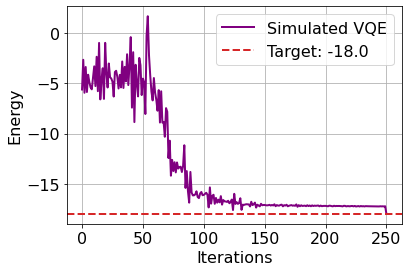

In [14]:
# plot the convergence of the VQE iterations to the ground state energy
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
gs_energy = -18.0
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

## Evaluation
This result is very close to the actual ground state energy of $-18$. Inspecting the optimal parameter values, we notice these are (up to integer multiples of $\pi$) close to $\theta = \frac{\pi}{4} \cdot (1,0,1,0,1,0,1,0,1,0,1)$. We therefore suggest that with our quantum circuit, 'kagome_ansatz', we can compute the ground state exactly. 

In [12]:
from qiskit import Aer, transpile

sim_statevector = Aer.get_backend('aer_simulator_statevector')
sim_kagome = QuantumCircuit(12)
for i in range(5):      
    W_entangler(sim_kagome,[2*i+1,(2*i+2)%12,(2*i+3)%12],'t'+str(i))

# entangle the last qubit with the first (still free) qubit in the lattice
W_entangler(sim_kagome,[11,0],'t'+str(5))

# use (optimal) ground state parameters and bind them to the circuit
x0 = np.pi/4 * np.array([1,0,1,0,1,0,1,0,1,0,1])

params = sim_kagome.parameters
t_dict = {params[i]: ((i+1)%2)*np.pi/4 for i in range(11)}
sim_kagome.assign_parameters(t_dict,inplace=True)

# save the state vector of the ground state
sim_kagome.save_statevector()

transpile(kagome_ansatz,sim_statevector)

result = sim_statevector.run(sim_kagome,ham_16).result()
statevector = result.get_statevector(sim_kagome)
state_vec_arr = np.asarray(statevector).flatten()

for i in range(len(state_vec_arr)):
    if not state_vec_arr[i] == 0:
        print("%.3f |%s>" % (np.round(state_vec_arr[i],3), format(i,'012b')))

-0.125 |001010101011>
0.125 |001010101101>
0.125 |001010110011>
-0.125 |001010110101>
0.125 |001011001011>
-0.125 |001011001101>
-0.125 |001011010011>
0.125 |001011010101>
0.125 |001100101011>
-0.125 |001100101101>
-0.125 |001100110011>
0.125 |001100110101>
-0.125 |001101001011>
0.125 |001101001101>
0.125 |001101010011>
-0.125 |001101010101>
0.125 |010010101011>
-0.125 |010010101101>
-0.125 |010010110011>
0.125 |010010110101>
-0.125 |010011001011>
0.125 |010011001101>
0.125 |010011010011>
-0.125 |010011010101>
-0.125 |010100101011>
0.125 |010100101101>
0.125 |010100110011>
-0.125 |010100110101>
0.125 |010101001011>
-0.125 |010101001101>
-0.125 |010101010011>
0.125 |010101010101>
0.125 |101010101010>
-0.125 |101010101100>
-0.125 |101010110010>
0.125 |101010110100>
-0.125 |101011001010>
0.125 |101011001100>
0.125 |101011010010>
-0.125 |101011010100>
-0.125 |101100101010>
0.125 |101100101100>
0.125 |101100110010>
-0.125 |101100110100>
0.125 |101101001010>
-0.125 |101101001100>
-0.125 |101

C:\Users\keckert\AppData\Local\Temp/ipykernel_3056/2752050558.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  print("%.3f |%s>" % (np.round(state_vec_arr[i],3), format(i,'012b')))


In [13]:
# Define a simple callback function
intermediate_info_sim = []
def callback_sim(value):
        intermediate_info_sim.append(value)

In [31]:
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import (QiskitRuntimeService, Session, Estimator as RuntimeEstimator)

QiskitRuntimeService.save_account(channel="ibm_quantum", token="a25c2de7fba634b2157af2ffb30cdcc9308e14a848e7ab959998e09039d19b4bb8310654409a6be536191b7181d01036b0df144e791d1b9c700281d2d9e8f098",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

backend = 'simulator_statevector'

start = time()
with Session(service=service, backend=backend) as session:
    
    # Define instance of qiskit-terra's Estimator primitive
    rt_estimator = RuntimeEstimator(session=session)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)

end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': None,
    'eigenvalue': -17.793329811903224,
    'optimal_circuit': None,
    'optimal_parameters': array([-2.40245966, -0.0103389 ,  0.83159428, -0.00863172,  2.4821436 ,
        3.19461893, -0.62086789,  3.14431538, -0.74926245,  3.14660173,
        0.80810281]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 119.17


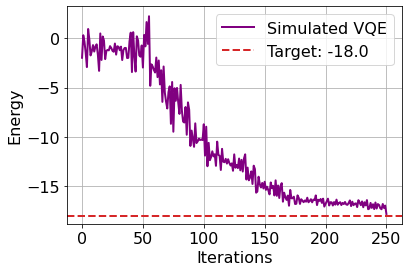

In [32]:
plt.plot(intermediate_info_sim, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
gs_energy = -18.0
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

## Now we use the physical hardware (ibmq_guadalupe) to reproduce this result

In [23]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
QiskitRuntimeService.save_account(channel="ibm_quantum", token="a25c2de7fba634b2157af2ffb30cdcc9308e14a848e7ab959998e09039d19b4bb8310654409a6be536191b7181d01036b0df144e791d1b9c700281d2d9e8f098",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

In [24]:
backend = 'ibmq_guadalupe'

In [25]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [26]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')
print(result)

runtime_job._start_websocket_client:WARNING:2023-03-04 20:20:32,555: An error occurred while streaming results from the server for job cg1l219g15oh53bjdlu0:
Traceback (most recent call last):
  File "C:\Users\keckert\Anaconda3\lib\site-packages\qiskit_ibm_runtime\runtime_job.py", line 454, in _start_websocket_client
    self._ws_client.job_results()
  File "C:\Users\keckert\Anaconda3\lib\site-packages\qiskit_ibm_runtime\api\clients\runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "C:\Users\keckert\Anaconda3\lib\site-packages\qiskit_ibm_runtime\api\clients\base.py", line 230, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "C:\\Users\\keckert\\Anaconda3\\lib\\site-packages\\websocket\\_http.py", line 155, in _get_addrinfo_list\n    addrinfo_list =

RequestsApiError: "HTTPSConnectionPool(host='runtime-us-east.quantum-computing.ibm.com', port=443): Max retries exceeded with url: /sessions/cg1l219g15oh53bjdlu0/close (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000218CF6B5940>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))"

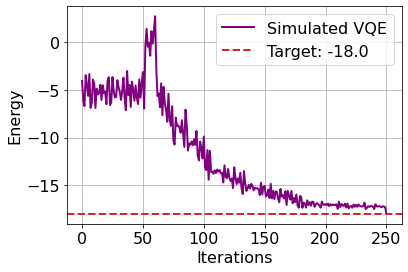

In [42]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [43]:
intermediate_info_sim_backend[-1]

-17.97

In [24]:
backend = 'ibmq_guadalupe'

In [25]:
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

In [ ]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

# Kagome lattice with 3 cells (24 spins)

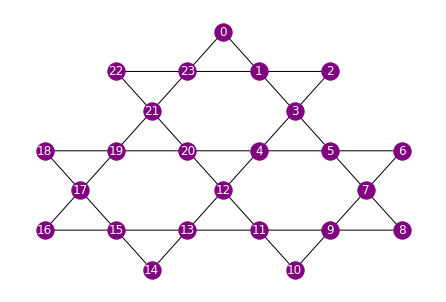

In [14]:
# Large Kagome lattice consisting of 3 cells, using 24 qubits
import rustworkx as rx
from qiskit_nature.problems.second_quantization.lattice import Lattice

num_qubits = 24
# edge weight
t = 1.0

graph_24 = rx.PyGraph(multigraph=False)
graph_24.add_nodes_from(range(num_qubits))

edge_list = [
    (0,1,t),
    (0,23,t),
    (1,2,t),
    (1,3,t),
    (1,23,t),
    (2,3,t),
    (3,4,t),
    (3,5,t),
    (4,5,t),
    (4,12,t),
    (4,20,t),
    (5,6,t),
    (5,7,t),
    (6,7,t),
    (7,8,t),
    (7,9,t),
    (8,9,t),
    (9,10,t),
    (9,11,t),
    (10,11,t),
    (11,12,t),
    (11,13,t),
    (12,13,t),
    (12,20,t),
    (13,14,t),
    (13,15,t),
    (14,15,t),
    (15,16,t),
    (15,17,t),
    (16,17,t),
    (17,18,t),
    (17,19,t),
    (18,19,t),
    (19,20,t),
    (19,21,t),
    (20,21,t),
    (21,22,t),
    (21,23,t),
    (22,23,t)   
]

graph_24.add_edges_from(edge_list)
kagome_3_cell = Lattice(graph_24)
r = np.sqrt(3)
node_pos = {0:[0,3*r],1:[1,2*r],2:[3,2*r],3:[2,r],4:[1,0],5:[3,0],6:[5,0],7:[4,-r],8:[5,-2*r],
           9:[3,-2*r],10:[2,-3*r],11:[1,-2*r],12:[0,-r],13:[-1,-2*r],14:[-2,-3*r],15:[-3,-2*r],
           16:[-5,-2*r],17:[-4,-r],18:[-5,0],19:[-3,0],20:[-1,0],21:[-2,r],22:[-3,2*r],23:[-1,2*r]}
kagome_3_cell.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':node_pos})
plt.show()

In [15]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from heisenberg_model import HeisenbergModel

# Build Hamiltonian from graph edges
heis_24 = HeisenbergModel.uniform_parameters(
    lattice=kagome_3_cell,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_24 = 4 * log_mapper.map(heis_24.second_q_ops().simplify())

ham_24

PauliSumOp(SparsePauliOp(['ZZIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIIIIIII', 'IIZIZIIIIIIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIIIIIII', 'IIIIZIZIIIIIIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIIIIIII', 'IIIIIIZIZIIIIIIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIIIIIII', 'IIIIIIIIZZIIIIIIIIIIIIII', 'IIIIIIIIZIZIIIIIIIIIIIII', 'IIIIIIIIIZZIIIIIIIIIIIII', 'IIIZIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIZZIIIIIIIIIIII', 'IIIIIIIIIIZIZIIIIIIIIIII', 'IIIIIIIIIIIZZIIIIIIIIIII', 'IIIIIIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIIIIZIZIIIIIIIII', 'IIIIIIIIIIIIIZZIIIIIIIII', 'IIIIIIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIIIIZIZIIIIIII', 'IIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIZIZIIIII', 'IIIIIIIIIIIIIIIIIZZIIIII', 'IIIZIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIZIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIZIZIII', 'IIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIZZII', 'ZIIIIIIIIIIIIIIIIIIII

In [16]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
# exact_solver = NumPyEigensolver(k=3)
# exact_result = exact_solver.compute_eigenvalues(ham_24)
# print(exact_result.eigenvalues)

# Save ground state energy for later
# gs_energy = np.round(exact_result.eigenvalues[0], 4)

### TAKES TOO MANY RESOURCES

In [17]:
kagome24 = QuantumCircuit(24)

for i in range(11):
    W_entangler(kagome24,[2*i+1,2*i+2,2*i+3],'t'+str(i))
    
W_entangler(kagome24,[23,0],'t11')

# kagome24.draw("mpl")

In [23]:
intermediate_info_sim24 = []
def callback_sim24(value):
        intermediate_info_sim24.append(value)

In [24]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
QiskitRuntimeService.save_account(channel="ibm_quantum", token="a25c2de7fba634b2157af2ffb30cdcc9308e14a848e7ab959998e09039d19b4bb8310654409a6be536191b7181d01036b0df144e791d1b9c700281d2d9e8f098",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

backend = 'simulator_statevector'

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, kagome24, optimizer, callback=callback_sim24)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_24)
end = time()
print(f'execution time (s): {end - start:.2f}')
print(result)

execution time (s): 14676.12
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': None,
    'eigenvalue': -33.514,
    'optimal_circuit': None,
    'optimal_parameters': array([ 0.58387218, -0.35830098,  0.71505607,  0.06914899,  0.62143096,
       -0.66471932,  3.2461919 , -0.64530006,  2.78761501,  3.57450211,
        0.45002807,  0.53474681, -0.20652921,  0.97060802, -0.02760371,
        0.81501405, -0.04489799,  0.71355343, -0.08546985,  2.34167917,
        3.16083143,  3.879301  , -0.05089663]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}


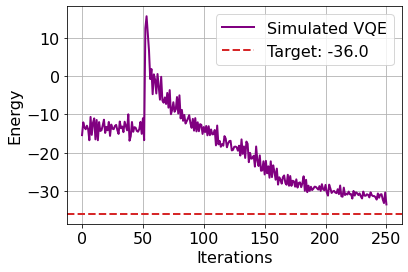

In [26]:
plt.plot(intermediate_info_sim24, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
gs_energy24 = -36.0
plt.axhline(y=gs_energy24, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy24))
plt.legend()
plt.grid()
plt.show()